In [1]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import entropy
from scipy.special import softmax

In [2]:
model_types = ["teacher", "BERT", "LSTM"]
glue_tasks = ["CoLA", "SST-2", "Sara"]
classes = {"CoLA": np.arange(2), "SST-2": np.arange(2), "Sara": np.arange(57)}

# Comparing models for a given task

In [3]:
N = 5
for task in glue_tasks:
    print(task)
    for model_type in model_types:
        data = pd.read_csv("predictions/dev_scored_{}_{}.tsv".format(task, model_type), delimiter="\t")
        
        # Average entropy
        Hs = []
        for i, sample in data.iterrows():
            logits = np.array([float(l) for l in sample["logits"].split(",")])
            Hs.append(entropy(softmax(logits)))
        H_mean = np.mean(Hs)
        H_std = np.std(Hs)
        print("H({}) = {:.3f}±{:.4f}".format(model_type, H_mean, H_std))
        
        mistakes = data[data["pred"] != data["label"]].sort_values(by="certainty_of_pred", ascending=False)
        hits = data[data["pred"] == data["label"]].sort_values(by="certainty_of_pred", ascending=False)
        print("Made {} mistakes out of {} ({:.0f}% rate)"\
              .format(len(mistakes), len(data), 100*(1-len(mistakes)/len(data))))
        examples = {}
        examples["confident mistakes"] = mistakes[:N]
        examples["unconfident mistakes"] = mistakes[-N:][::-1]
        examples["confident hits"] = hits[:N]
        examples["unconfident hits"] = hits[-N:][::-1]
        with open("mistakes-hits/{}_{}.txt".format(task, model_type), "w") as f:
            for kind in ["confident mistakes", "unconfident mistakes", "confident hits", "unconfident hits"]:
                f.write("\n{}\n".format(kind))
                for i, ex in examples[kind].iterrows():
                    f.write("{:.3f} ({}): {}\n".format(ex["certainty_of_pred"], ex["label"], ex["sentence"]))
# TO-DO: SEPARATE EXAMPLES BY CLASS (I.E. HAVING CONFIDENT UNACCAPTABLE VS ACCEPTABLE MISTAKES, ETC)

CoLA
H(teacher) = 0.206±0.1548
Made 169 mistakes out of 1043 (84% rate)
H(BERT) = 0.253±0.1862
Made 228 mistakes out of 1043 (78% rate)
H(LSTM) = 0.282±0.1921
Made 238 mistakes out of 1043 (77% rate)
SST-2
H(teacher) = 0.101±0.1316
Made 74 mistakes out of 872 (92% rate)
H(BERT) = 0.149±0.1814
Made 93 mistakes out of 872 (89% rate)
H(LSTM) = 0.134±0.1665
Made 77 mistakes out of 872 (91% rate)
Sara
H(teacher) = 0.292±0.5136
Made 121 mistakes out of 970 (88% rate)
H(BERT) = 0.367±0.5852
Made 125 mistakes out of 970 (87% rate)
H(LSTM) = 0.506±0.7136
Made 131 mistakes out of 970 (86% rate)


# Playground

In [3]:
data = pd.read_csv("predictions/dev_scored_{}_{}.tsv".format("CoLA", "LSTM"), delimiter="\t")

## Quick info

In [4]:
data

,sentence,label,pred,certainty_of_pred,certainty_of_label,logits
0,the sailors rode the breeze clear of the rocks.,1,1,0.969,0.969,"-2.0777724,1.3549101"
1,the weights made the rope stretch over the pul...,1,1,0.972,0.972,"-2.1502833,1.4040403"
2,the mechanical doll wriggled itself loose.,1,1,0.960,0.960,"-1.9746174,1.2129471"
3,"if you had eaten more, you would want less.",1,1,0.947,0.947,"-1.8209175,1.0607835"
4,"as you eat the most, you want the least.",0,1,0.856,0.144,"-1.14807,0.6344539"
...,...,...,...,...,...,...
1038,john considers bill silly.,1,1,0.978,0.978,"-2.240571,1.5472332"
1039,john considers bill to be silly.,1,1,0.984,0.984,"-2.3931918,1.72282"
1040,john bought a dog for himself to play with.,0,1,0.760,0.240,"-0.7178209,0.4342072"
1041,john arranged for himself to get the prize.,1,1,0.973,0.973,"-2.1123729,1.4771334"


In [5]:
data.describe()

,label,pred,certainty_of_pred,certainty_of_label
count,1043.000000,1043.000000,1043.000000,1043.000000
mean,0.691275,0.746884,0.891261,0.730762
std,0.462189,0.435005,0.119072,0.337798
min,0.000000,0.000000,0.500000,0.008000
25%,0.000000,0.000000,0.858500,0.561000
50%,1.000000,1.000000,0.941000,0.920000
75%,1.000000,1.000000,0.976000,0.975000
max,1.000000,1.000000,0.992000,0.989000


# Checking peakiness of logit distributions

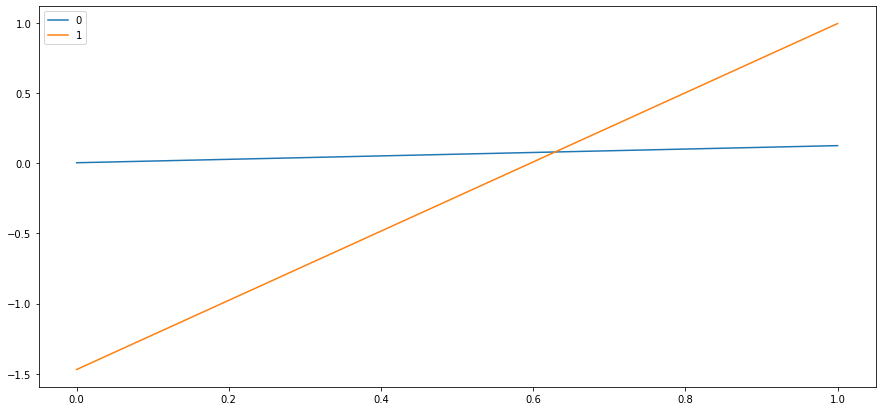

In [7]:
glue_task = "CoLA"

logits_avg = {kind: {cls: np.zeros_like(classes[glue_task], dtype=np.float) for cls in classes[glue_task]} 
              for kind in ["true", "pred"]}

for i, sample in data.iterrows():
    logits = np.array([float(l) for l in sample["logits"].split(",")])
    logits_avg["true"][sample["label"]] += logits
    logits_avg["pred"][sample["pred"]] += logits
for cls in classes[glue_task]:
    n_pred = (data["pred"] == cls).sum()
    n_true = (data["label"] == cls).sum()
    if n_pred != 0:
        logits_avg["pred"][cls] /= n_pred
    logits_avg["true"][cls] /= n_true
plt.figure(figsize=(15, 7))
for cls in classes[glue_task]:
    plt.plot(logits_avg["true"][cls], label=cls)
plt.legend()
plt.show()

# Computing average entropy

In [8]:
entropies = []
for i, sample in data.iterrows():
    logits = np.array([float(l) for l in sample["logits"].split(",")])
    probs = softmax(logits)
    H = entropy(probs)
    entropies.append(H)
H_mean = np.mean(entropies)
H_std = np.std(entropies)
print(H_mean, H_std)

0.2820318261129553 0.19211760758900245
